In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.float_format = "{:,.2f}".format
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import warnings
warnings.simplefilter("ignore")
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv
/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv


In [2]:
#user defined functions
def extract_categorycode(input_text,level=0):
    '''
     this function splits category code and returns the first part.
    '''
    output_text=input_text.split('.')[level]
    return output_text

def create_clusters(input_data_frame,input_columns,n_cluster):
    '''
     This function creates clusters and cluster labels.
    '''
    from sklearn.cluster import KMeans
    X=input_data_frame[input_columns].values
    k_means=KMeans(n_clusters=n_cluster,random_state=15).fit(X)
    return k_means.labels_

In [3]:
#reading data
file_loc="/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv"
dataset=pd.read_csv(file_loc)

In [4]:
dataset.drop(columns=['category_id'],inplace=True)
dataset['event_time']=pd.to_datetime(dataset['event_time']).dt.tz_convert(None)
dataset['event_type']=dataset['event_type'].astype('category')
dataset['category_code']=dataset['category_code'].astype('category')

# General Summary

In [5]:
#creating a summary table for general overview
daily_summary_table=dataset.groupby(by=[dataset['event_time'].dt.normalize()]).agg(Number_of_daily_visits=('user_session',lambda x: x.nunique()),
                                                                                  Number_of_daily_visitors=('user_id',lambda x: x.nunique())
                                                                                  )
sales_filter=dataset['event_type']=='purchase'
sales=dataset.loc[sales_filter].groupby(by=[dataset['event_time'].dt.normalize()]).agg(number_of_daily_sales=('event_type','count'),
                                                                                      Total_daily_sales=('price','sum')
                                                                                      ).reset_index()
daily_summary_table=pd.merge(left=daily_summary_table,
                          right=sales,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')
daily_summary_table['conversion_rate']=daily_summary_table['number_of_daily_sales']/daily_summary_table['Number_of_daily_visits']

Daily Visits Statistics
--------------------------------------------------
count        31.00
mean    299,510.55
std      25,531.55
min     241,086.00
25%     278,957.50
50%     301,219.00
75%     319,668.50
max     339,943.00
Name: Number_of_daily_visits, dtype: float64
--------------------------------------------------
Visit Statistics by Dates
--------------------------------------------------
            count       mean       std        min        25%        50%  \
event_time                                                                
Friday       4.00 321,772.50 16,017.26 300,651.00 313,704.00 325,731.00   
Monday       4.00 293,353.00 26,033.15 263,437.00 276,610.00 294,346.50   
Saturday     4.00 298,041.75 19,140.22 276,914.00 286,412.75 296,976.50   
Sunday       4.00 309,080.00 32,756.35 273,034.00 285,634.75 311,671.50   
Thursday     5.00 282,820.60 24,557.36 241,086.00 281,446.00 293,587.00   
Tuesday      5.00 301,032.40 27,672.77 268,737.00 276,723.00 308,348.00   


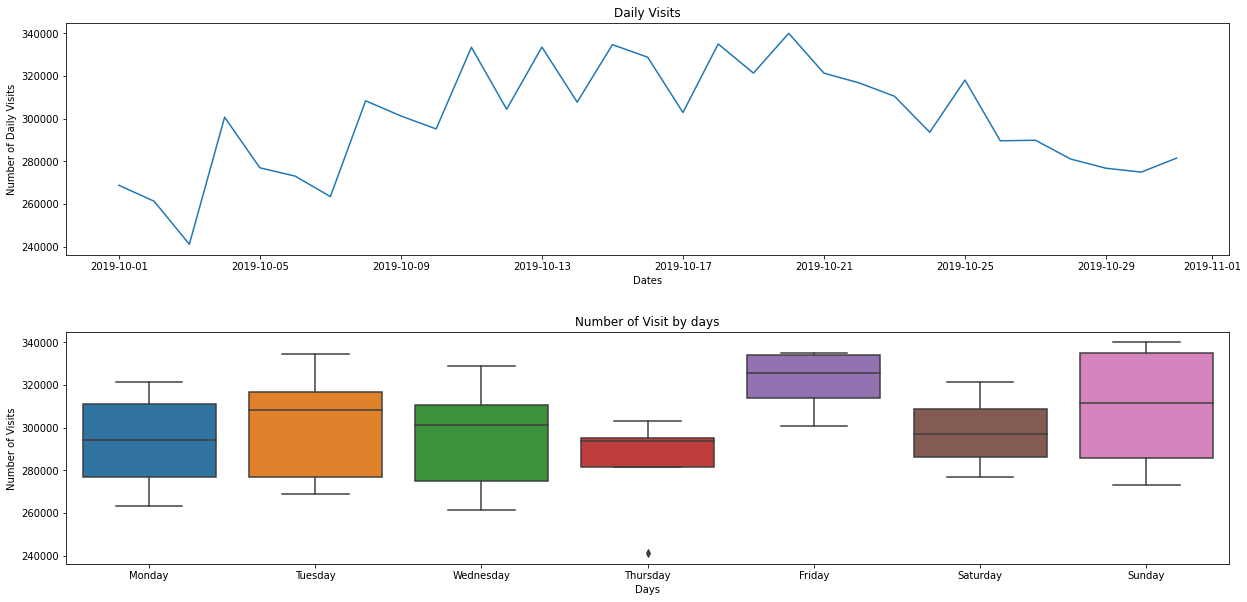

In [6]:
#Daily Visits
print('Daily Visits Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_visits'].describe())
print('-'*50)
print('Visit Statistics by Dates')
print('-'*50)
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name())['Number_of_daily_visits'].describe())

#Plotting number of daily visits
fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1)
sns.lineplot(x='event_time',
              y='Number_of_daily_visits',
              data=daily_summary_table,
             ax=ax1)
plt.title('Daily Visits')
plt.ylabel('Number of Daily Visits')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek,
            y='Number_of_daily_visits',
            data=daily_summary_table,
           ax=ax2)
plt.title('Number of Visit by days')
plt.ylabel('Number of Visits')
plt.xlabel('Days')
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0);

Daily Visitor Statistics
--------------------------------------------------
count        31.00
mean    208,829.77
std      16,233.61
min     170,668.00
25%     195,260.50
50%     208,477.00
75%     223,321.00
max     231,849.00
Name: Number_of_daily_visitors, dtype: float64
--------------------------------------------------
Visitor Statistics by Dates
--------------------------------------------------
            count       mean       std        min        25%        50%  \
event_time                                                                
Friday       4.00 223,166.00  9,715.30 209,410.00 219,796.00 226,360.50   
Monday       4.00 204,218.00 16,732.50 186,951.00 193,410.00 202,326.00   
Saturday     4.00 205,851.25  9,731.79 194,958.00 200,368.50 205,263.50   
Sunday       4.00 213,090.00 18,707.44 193,210.00 199,321.75 213,650.50   
Thursday     5.00 197,994.80 15,736.89 170,668.00 198,571.00 205,321.00   
Tuesday      5.00 211,615.80 18,526.04 190,188.00 193,168.00 221,204.0

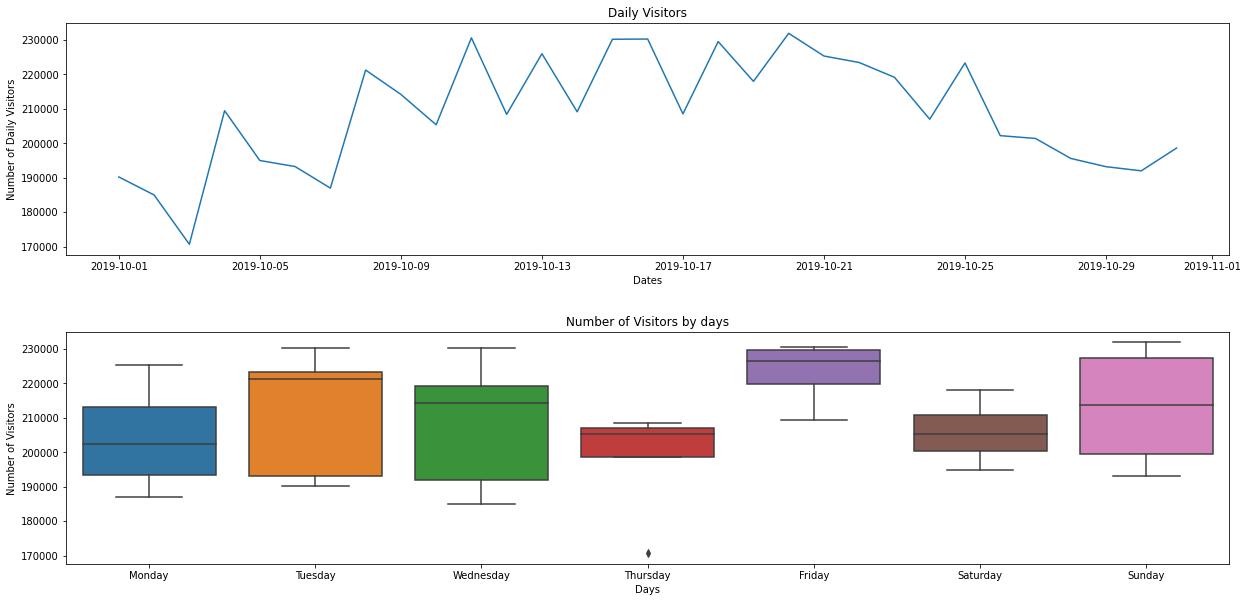

In [7]:
#Daily Visitors
print('Daily Visitor Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_visitors'].describe())
print('-'*50)
print('Visitor Statistics by Dates')
print('-'*50)
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name())['Number_of_daily_visitors'].describe())

#Plotting number of daily visitors
fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1)
sns.lineplot(x='event_time',
              y='Number_of_daily_visitors',
              data=daily_summary_table,
            ax=ax1)
plt.title('Daily Visitors')
plt.ylabel('Number of Daily Visitors')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)
sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek,
            y='Number_of_daily_visitors',
            data=daily_summary_table,
           ax=ax2)
plt.title('Number of Visitors by days')
plt.ylabel('Number of Visitors')
plt.xlabel('Days')
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0);

Conversion Rates Statistics
--------------------------------------------------
count   31.00
mean     0.08
std      0.01
min      0.07
25%      0.08
50%      0.08
75%      0.08
max      0.10
Name: conversion_rate, dtype: float64
--------------------------------------------------
Conversion Rates Statistics by Dates
--------------------------------------------------
            count  mean  std  min  25%  50%  75%  max
event_time                                           
Friday       4.00  0.08 0.01 0.08 0.08 0.08 0.08 0.09
Monday       4.00  0.08 0.01 0.08 0.08 0.08 0.08 0.09
Saturday     4.00  0.08 0.00 0.08 0.08 0.08 0.08 0.08
Sunday       4.00  0.08 0.01 0.07 0.08 0.08 0.08 0.09
Thursday     5.00  0.08 0.01 0.07 0.07 0.08 0.08 0.09
Tuesday      5.00  0.08 0.00 0.07 0.07 0.07 0.08 0.08
Wednesday    5.00  0.08 0.01 0.07 0.08 0.08 0.08 0.10


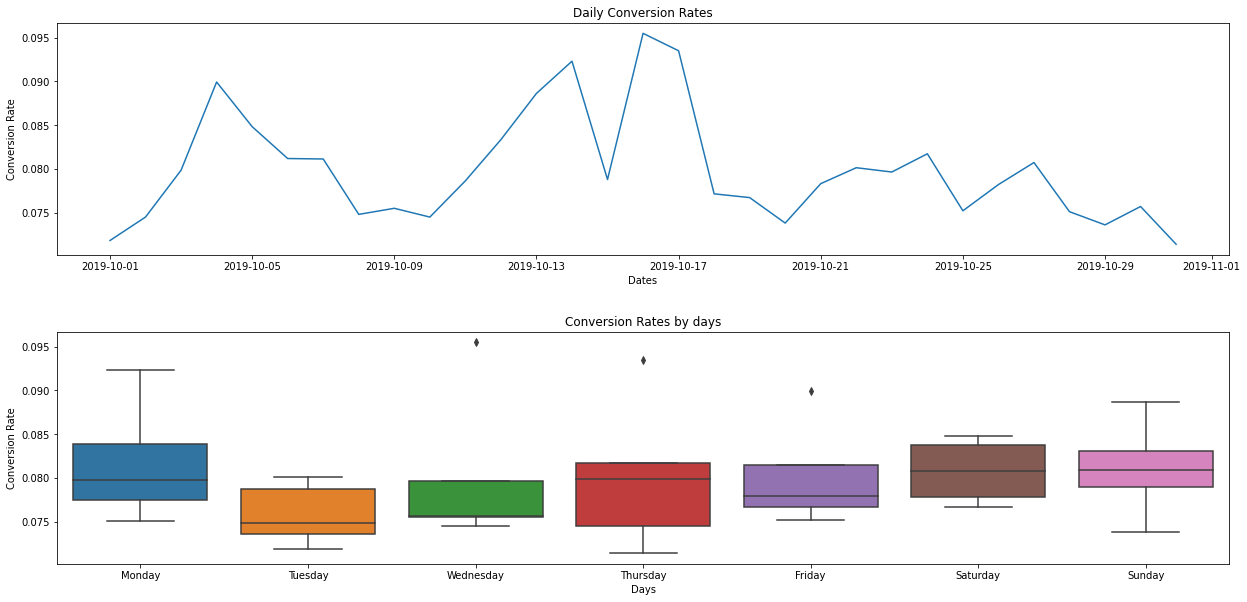

In [8]:
#Conversion rates
print('Conversion Rates Statistics')
print('-'*50)
print(daily_summary_table['conversion_rate'].describe())
print('-'*50)
print('Conversion Rates Statistics by Dates')
print('-'*50)
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name())['conversion_rate'].describe())

#Plotting convergance rates
fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1)
sns.lineplot(x='event_time',
              y='conversion_rate',
              data=daily_summary_table,
            ax=ax1)
plt.title('Daily Conversion Rates')
plt.ylabel('Conversion Rate')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)
sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek,
            y='conversion_rate',
            data=daily_summary_table,
           ax=ax2)
plt.title('Conversion Rates by days')
plt.ylabel('Conversion Rate')
plt.xlabel('Days')
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0);

# Customer Analysis

In [9]:
#creating a customer table

#Filtering sales activities
sales_filter=dataset['event_type']=='purchase'
Customer_table=dataset.loc[sales_filter].groupby(by=['user_id']).agg(number_of_purchases=('user_id','count'),
                                                                     total_sales=('price','sum')).reset_index()

**Repeat Customer**

Customer who buys more than once.

In [10]:
#Calculating number of customers who bought something
Number_of_customers_who_bought_smt=Customer_table['user_id'].nunique()
print('There are {:,.0f} customers, who purchased in October.'.format(Number_of_customers_who_bought_smt))

#Calculating number of purchase activities for each customer
print('-'*50)
print('Distribution of Customer by Number of Purchases')
print(Customer_table['number_of_purchases'].value_counts(normalize=True).head(10))
#Calculationg repeat customers number
print('-'*50)
more_than_one_purchase_filter=Customer_table['number_of_purchases']>1
Number_of_customers_who_bought_more_than_once=Customer_table.loc[more_than_one_purchase_filter].shape[0]
print('There are {:,.0f} repeat customers, who bought more than once.'.format(Number_of_customers_who_bought_more_than_once))

There are 347,118 customers, who purchased in October.
--------------------------------------------------
Distribution of Customer by Number of Purchases
1    0.62
2    0.19
3    0.07
4    0.04
5    0.02
6    0.01
7    0.01
8    0.01
9    0.00
10   0.00
Name: number_of_purchases, dtype: float64
--------------------------------------------------
There are 131,427 repeat customers, who bought more than once.


             user_id  number_of_purchases  total_sales
count     347,118.00           347,118.00   347,118.00
mean  535,997,020.53                 2.14       662.48
std    18,498,600.84                 3.64     2,074.37
min   264,649,825.00                 1.00         0.88
25%   517,104,155.50                 1.00       107.59
50%   535,167,878.50                 1.00       246.52
75%   554,803,791.00                 2.00       595.01
max   566,278,294.00               322.00   265,569.52
             user_id  number_of_purchases  total_sales
count     326,294.00           326,294.00   326,294.00
mean  536,121,594.88                 1.72       402.10
std    18,526,372.41                 1.54       452.16
min   264,649,825.00                 1.00         9.91
25%   517,202,069.25                 1.00       103.50
50%   535,386,226.00                 1.00       230.79
75%   555,016,143.25                 2.00       513.48
max   566,278,294.00                60.00     2,339.25


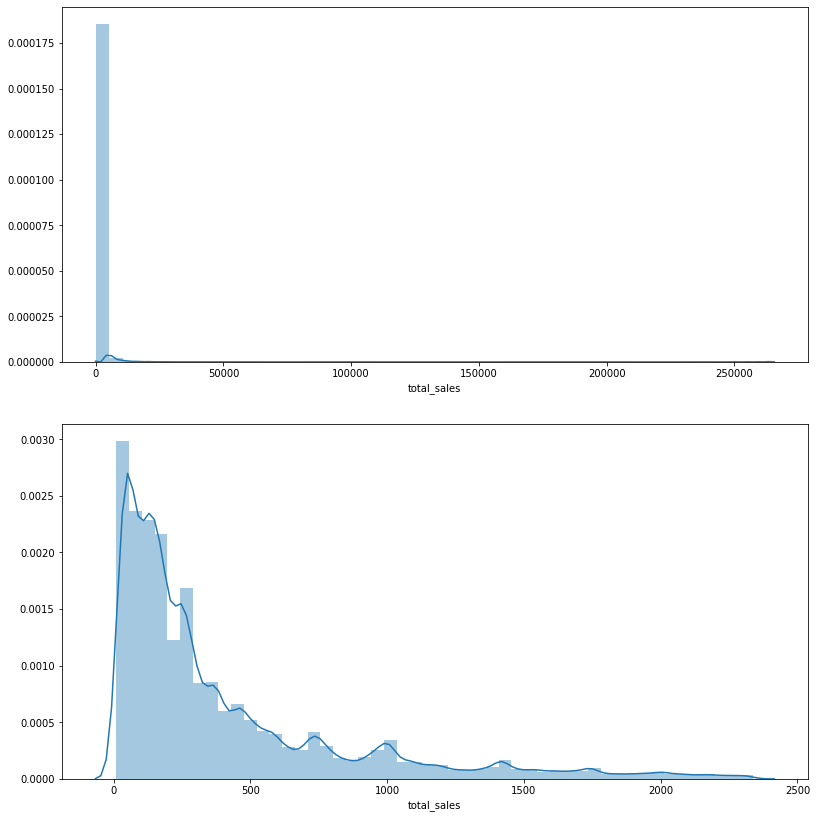

In [11]:
#filtering out the extreme values
sales_threshold=np.percentile(Customer_table['total_sales'],[1,95])
sales_threshold_filter=np.logical_and(Customer_table['total_sales']>=sales_threshold[0],
                                      Customer_table['total_sales']<=sales_threshold[1])
sales_filtered=Customer_table.loc[sales_threshold_filter]
print(Customer_table.describe())
print(sales_filtered.describe())

fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,1,1)
sns.distplot(Customer_table['total_sales'],
            ax=ax1)

ax2=fig.add_subplot(2,1,2)
sns.distplot(sales_filtered['total_sales'],
            ax=ax2)

fig.tight_layout(pad=3.0);

In [12]:
#Most valuable customers

#filtering customer with top %10 purchase amount
top10perc_sales_amount=np.percentile(Customer_table['total_sales'],90)
filter_top10perc_sales_amount=Customer_table['total_sales']>=top10perc_sales_amount
top10perc_customers_with_hightest_turnover=Customer_table.loc[filter_top10perc_sales_amount]
regular_customers=Customer_table.loc[~filter_top10perc_sales_amount]

#calculating descriptive statistics
print('Top 10% customers Purchase Amount-Descriptive Statistics')
print('-'*50)
print(top10perc_customers_with_hightest_turnover['total_sales'].describe())
print('-'*50)
total_sales_amount=Customer_table['total_sales'].sum()
print('Total sales: {:,.0f}'.format(total_sales_amount))
total_sales_amount_top10perc=top10perc_customers_with_hightest_turnover['total_sales'].sum()
print('Total sales of top 10% customers: {:,.0f}'.format(total_sales_amount_top10perc))

#calculating descriptive statistics
print('Regular customers Purchase Amount-Descriptive Statistics')
print('-'*50)
print(regular_customers['total_sales'].describe())
print('-'*50)
total_sales_amount_regular_customers=regular_customers['total_sales'].sum()
print('Total sales of regular customers: {:,.0f}'.format(total_sales_amount_regular_customers))

Top 10% customers Purchase Amount-Descriptive Statistics
--------------------------------------------------
count    34,712.00
mean      3,735.44
std       5,625.45
min       1,418.31
25%       1,741.34
50%       2,339.25
75%       3,771.48
max     265,569.52
Name: total_sales, dtype: float64
--------------------------------------------------
Total sales: 229,957,502
Total sales of top 10% customers: 129,664,534
Regular customers Purchase Amount-Descriptive Statistics
--------------------------------------------------
count   312,406.00
mean        321.03
std         314.94
min           0.88
25%          94.21
50%         205.08
75%         442.68
max       1,418.25
Name: total_sales, dtype: float64
--------------------------------------------------
Total sales of regular customers: 100,292,968


Cluster Statistics
--------------------------------------------------
             count     mean      std      min      25%      50%      75%  \
cluster                                                                    
0.00     33,357.00 1,048.88   175.19   779.81   922.00 1,005.30 1,167.54   
1.00    206,920.00   137.95    86.58     0.88    59.20   131.02   201.26   
2.00     72,129.00   509.65   131.06   324.08   390.75   483.92   603.62   
3.00     34,712.00 3,735.44 5,625.45 1,418.31 1,741.34 2,339.25 3,771.48   

               max  
cluster             
0.00      1,418.25  
1.00        324.07  
2.00        779.77  
3.00    265,569.52  


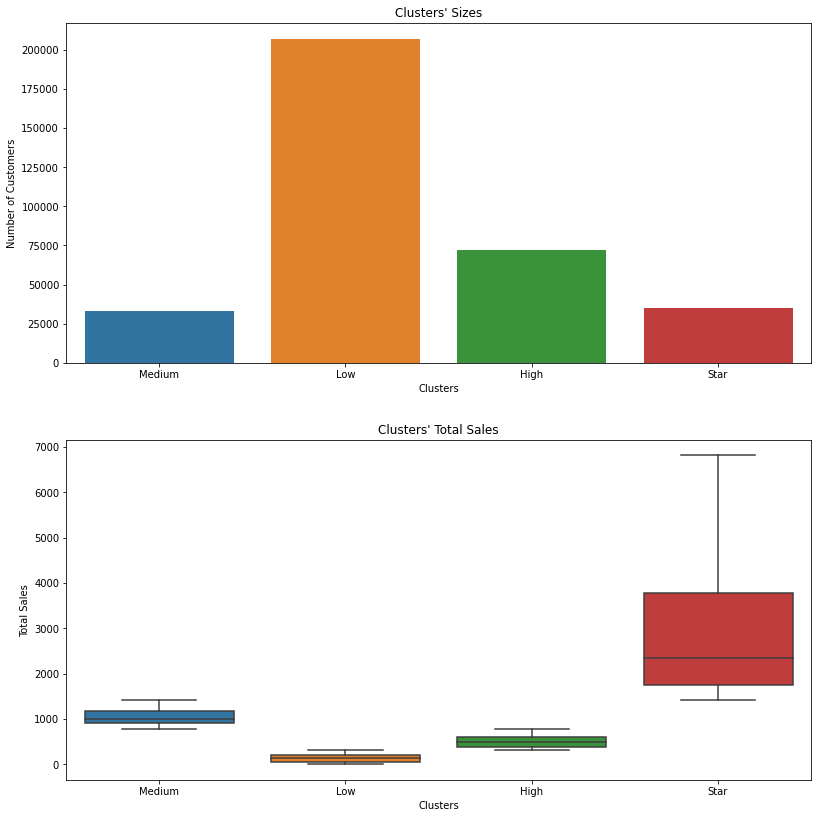

In [13]:
#creating subsegments from regular customers
from sklearn.cluster import KMeans
X=regular_customers['total_sales'].values.reshape(-1,1)
regular_customers['cluster']=Clustering_KMeans=KMeans(n_clusters=3,random_state=15).fit_predict(X)

#merging clusters
Customer_table=pd.merge(left=Customer_table,
                        right=regular_customers[['user_id','cluster']],
                        how='left',
                        left_on='user_id',
                        right_on='user_id')
Customer_table['cluster'].fillna(3,inplace=True)

#Plotting the clusters
print('Cluster Statistics')
print('-'*50)
print(Customer_table.groupby(by=['cluster'])['total_sales'].describe())

fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,1,1)
sns.countplot(x='cluster',data=Customer_table,ax=ax1)
plt.xlabel('Clusters')
plt.ylabel('Number of Customers')
plt.title("Clusters' Sizes")
ax1.set_xticklabels(['Medium','Low','High','Star']);

ax2=fig.add_subplot(2,1,2)
sns.boxplot(x='cluster',y='total_sales',data=Customer_table,ax=ax2,showfliers = False)
plt.xlabel('Clusters')
plt.ylabel('Total Sales')
plt.title("Clusters' Total Sales")
fig.tight_layout(pad=3.0)
ax2.set_xticklabels(['Medium','Low','High','Star']);

Customer Interest Groups

In [14]:
#creating a filter for shoppers 
shopper_filter=dataset['event_type']=='purchase'
#using the filter to create shopper user list
shopper_list=dataset.loc[shopper_filter,['user_id']]
#distincting shopper customer list
distinct_shopper_df=pd.DataFrame(shopper_list['user_id'].unique(),columns=['user_id'])
#creating shopper dataset
dataset_shoppers=pd.merge(left=dataset,
                          right=distinct_shopper_df,
                          how='inner',
                          left_on=['user_id'],
                          right_on=['user_id']
                          )

In [15]:
#Extracting category code level_1 from category code
dataset_shoppers['category_level_1']=dataset_shoppers['category_code'].apply(extract_categorycode)
#excluding unknown categories
filter_temp=dataset_shoppers['category_level_1']=='Unknown'
dataset_shoppers=dataset_shoppers.loc[~filter_temp]

#creating shoppers visit table that contains number of visits in each category 
shoppers_visit_table=dataset_shoppers.groupby(by=['user_id','category_level_1']).agg(Number_of_view=('user_id','count'))
shoppers_visit_table=shoppers_visit_table.reset_index()

#creating shoppers visit frequency table that contains total number of visit overall.
shoppers_visit_frequency=shoppers_visit_table.groupby(by=['user_id']).agg(n_visits=('Number_of_view','sum')).reset_index()

#creating the ratio column in shopper visit table 
shoppers_visit_table=pd.merge(left=shoppers_visit_table,
                              right=shoppers_visit_frequency,
                              left_on='user_id',
                              right_on='user_id',
                              how='left')
shoppers_visit_table['ratio']=shoppers_visit_table['Number_of_view']/shoppers_visit_table['n_visits']

In [16]:
'''
spliting shoppers into 2 different groups to create more homogenious interest groups. 
First group contains shoppers interested with only on category and the second group contains shoppers visited multiple categories.
'''
#creating first shopper group, focused customers.
focused_shoppers_filter=shoppers_visit_table['ratio']==1
focused_shoppers=shoppers_visit_table.loc[focused_shoppers_filter]
#assigning "focused customers" to seperate groups by their category interests
focused_shoppers['shoppers_interest_groups']=pd.factorize(focused_shoppers['category_level_1'])[0]+1

#creating second customer group, diversified customers.
diversified_shoppers=shoppers_visit_table.loc[~focused_shoppers_filter]
diversified_shoppers_pivot=pd.pivot_table(data=diversified_shoppers,values='ratio',index='user_id',columns='category_level_1')
diversified_shoppers_pivot.fillna(0,inplace=True)
diversified_shoppers_pivot.reset_index(inplace=True)

#creating subgroups for "diversified customers"
k_4_clusters=create_clusters(input_data_frame=diversified_shoppers_pivot,
                             input_columns=['accessories', 'apparel', 'appliances', 'auto','computers', 'construction', 'country_yard', 'electronics', 'furniture','kids', 'medicine', 'sport', 'stationery'],
                             n_cluster=4)
diversified_shoppers_pivot['cluster_k4means']=k_4_clusters

#profiling subgroups of diversified customers
input_columns=['cluster_k4means', 'accessories', 'apparel', 'appliances', 'auto','computers', 'construction', 'country_yard', 'electronics', 'furniture','kids', 'medicine', 'sport', 'stationery']                          
print(diversified_shoppers_pivot[input_columns].groupby(by='cluster_k4means').mean())
print(diversified_shoppers_pivot['cluster_k4means'].value_counts())

'''
diversified shoppers subgroups
0: 70k-appliances and mostly electronics
1: 30k-electronics and mostly appliances
2: 30k-Apparel, appliances, construction, electronics, furniture
3: 11k- Electronics and mostly computers
'''

category_level_1  accessories  apparel  appliances  auto  computers  \
cluster_k4means                                                       
0                        0.01     0.03        0.07  0.02       0.03   
1                        0.00     0.03        0.70  0.01       0.02   
2                        0.03     0.18        0.07  0.17       0.02   
3                        0.01     0.02        0.05  0.01       0.68   

category_level_1  construction  country_yard  electronics  furniture  kids  \
cluster_k4means                                                              
0                         0.01          0.00         0.80       0.02  0.01   
1                         0.02          0.00         0.17       0.04  0.01   
2                         0.10          0.00         0.17       0.16  0.07   
3                         0.01          0.00         0.20       0.02  0.01   

category_level_1  medicine  sport  stationery  
cluster_k4means                                
0       

'\ndiversified shoppers subgroups\n0: 70k-appliances and mostly electronics\n1: 30k-electronics and mostly appliances\n2: 30k-Apparel, appliances, construction, electronics, furniture\n3: 11k- Electronics and mostly computers\n'

In [17]:
#making space in the memory for category analysis
del focused_shoppers
del diversified_shoppers
del diversified_shoppers_pivot
del distinct_shopper_df
del Customer_table
del daily_summary_table

# Category Analysis

In [18]:
#splitting the category text into 2 pieces as category and subcategory
dataset['category']=dataset['category_code'].apply(extract_categorycode,level=0)
dataset['subcategory']=dataset['category_code'].apply(extract_categorycode,level=1)

In [19]:
#calculating and printing informative numerical information about the dataset.
total_number_of_activity=dataset.shape[0]
print('Total number of activity:{:,.0f}'.format(total_number_of_activity))
print('-'*50)
total_number_of_visits=dataset['user_session'].nunique()
print('Total number of visits:{:,.0f}'.format(total_number_of_visits))
print('-'*50)
total_number_of_visitors=dataset['user_id'].nunique()
print('Total number of visitors:{:,.0f}'.format(total_number_of_visitors))
print('-'*50)
number_of_categories=dataset['category'].nunique()
print('The number of categories:{:,.0f}'.format(number_of_categories))
print('-'*50)
number_of_subcategories=dataset['subcategory'].nunique()
print('The number of subcategories:{:,.0f}'.format(number_of_subcategories))
print('-'*50)
number_of_brands=dataset['brand'].nunique()
print('The number of brands:{:,.0f}'.format(number_of_brands))
print('-'*50)
number_of_products=dataset['product_id'].nunique()
print('The number of products:{:,.0f}'.format(number_of_products))

Total number of activity:42,448,764
--------------------------------------------------
Total number of visits:9,244,421
--------------------------------------------------
Total number of visitors:3,022,290
--------------------------------------------------
The number of categories:13
--------------------------------------------------
The number of subcategories:57
--------------------------------------------------
The number of brands:3,444
--------------------------------------------------
The number of products:166,794


In [20]:
#creating a summary table that contains an outline of categories and activities
category_summary_table=dataset.groupby(by=['category']).agg(Number_of_views=('category','count'),
                                                              Number_of_users=('user_id',lambda x: x.nunique()),
                                                              Number_of_sessions=('user_session',pd.Series.nunique)).reset_index()
sales_filter=dataset['event_type']=='purchase'
category_sales_summary_table=dataset.loc[sales_filter].groupby(by=['category']).agg(Number_of_purchase=('category','count'),
                                                                                      Amount_of_purchase=('price','sum'),
                                                                                      Average_purchase_amount=('price','mean'),
                                                                                      Number_of_sessions_with_purchase=('user_session',pd.Series.nunique),
                                                                                      Number_of_shoppers=('user_id',lambda x: x.nunique())).reset_index()
category_summary_table=pd.merge(left=category_summary_table,
                               right=category_sales_summary_table,
                               left_on='category',
                               right_on='category',
                               how='left')
category_summary_table['Conversion_rate']=category_summary_table['Number_of_purchase']/category_summary_table['Number_of_sessions']

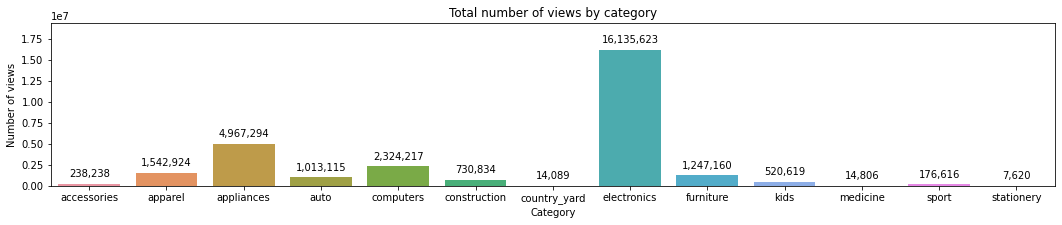

In [21]:
#creating a plot that illustrates number of visits in each category during October
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='Number_of_views',data=category_summary_table)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Total number of views by category')
plt.xlabel('Category')
plt.ylabel('Number of views')
plt.ylim(0,category_summary_table['Number_of_views'].max()*1.2);

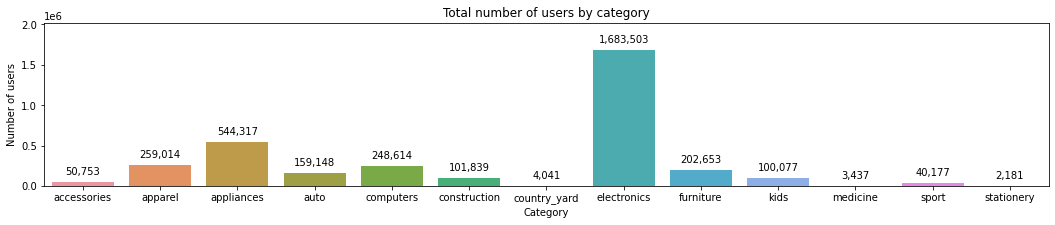

In [22]:
#creating a plot that illustrates number of visitors in each category during October
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='Number_of_users',data=category_summary_table)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Total number of users by category')
plt.xlabel('Category')
plt.ylabel('Number of users')
plt.ylim(0,category_summary_table['Number_of_users'].max()*1.2);

In [23]:
#creating a subcategory summary table
category_subcategory_summary_table=dataset.groupby(by=['category','subcategory']).agg(Number_of_views=('category','count'),
                                                              Number_of_users=('user_id',lambda x: x.nunique()),
                                                              Number_of_sessions=('user_session',pd.Series.nunique)).reset_index()
                                
sales_filter=dataset['event_type']=='purchase'
category_subcategory_sales_summary_table=dataset.loc[sales_filter].groupby(by=['category','subcategory']).agg(Number_of_purchase=('category','count'),
                                                                                      Amount_of_purchase=('price','sum'),
                                                                                      Average_purchase_amount=('price','mean'),
                                                                                      Number_of_sessions_with_purchase=('user_session',pd.Series.nunique),
                                                                                      Number_of_shoppers=('user_id',lambda x: x.nunique())).reset_index()
category_subcategory_summary_table=pd.merge(left=category_subcategory_summary_table,
                               right=category_subcategory_sales_summary_table,
                               left_on=['category','subcategory'],
                               right_on=['category','subcategory'],
                               how='left')
category_subcategory_summary_table['Conversion_rate']=category_subcategory_summary_table['Number_of_purchase']/category_subcategory_summary_table['Number_of_sessions']
category_subcategory_summary_table['category_subcategory']=category_subcategory_summary_table['category']+'-'+category_subcategory_summary_table['subcategory']

category_subcategory_summary_table_sorted=category_subcategory_summary_table.sort_values(by='Number_of_views', ascending=False)

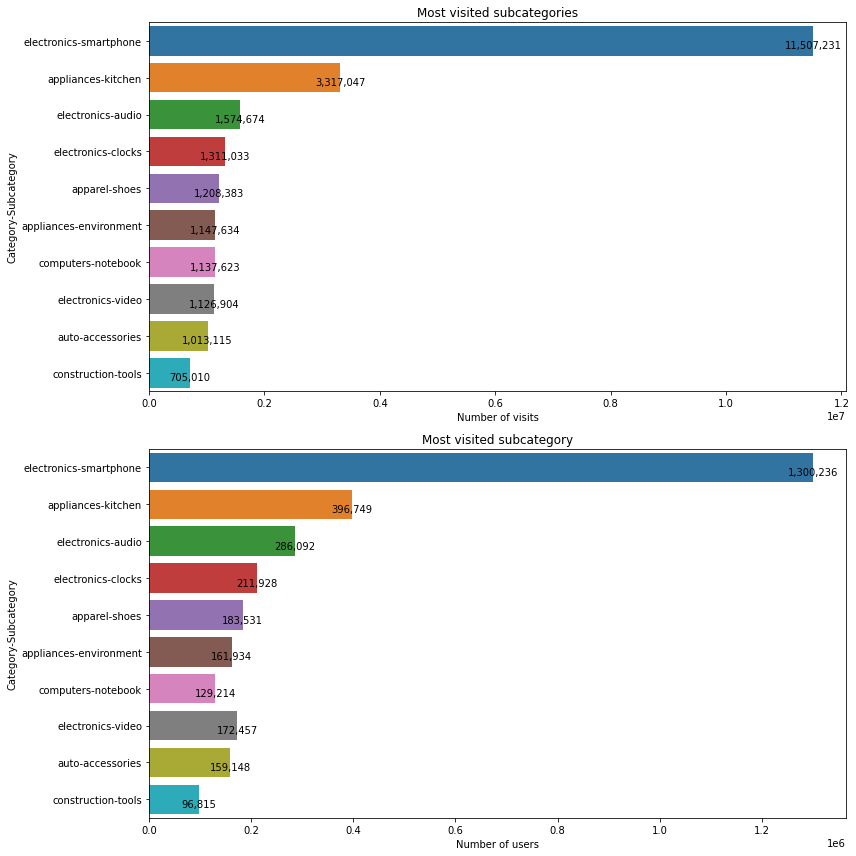

In [24]:
#creating a plot that shows most popular subcategories and number of visits and visitors during October
fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,1,1)
plot=sns.barplot(x='Number_of_views',y='category_subcategory',data=category_subcategory_summary_table_sorted.head(10),ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_width(), ',.0f'),
                  (p.get_x()+p.get_width(), p.get_y() + p.get_height() ),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')
plt.title('Most visited subcategories')
plt.xlabel('Number of visits')
plt.ylabel('Category-Subcategory')

ax2=fig.add_subplot(2,1,2)
plot=sns.barplot(x='Number_of_users',y='category_subcategory',data=category_subcategory_summary_table_sorted.head(10),ax=ax2)
for p in plot.patches:
    plot.annotate(format(p.get_width(), ',.0f'),
                  (p.get_x()+p.get_width(), p.get_y() + p.get_height() ),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Most visited subcategory')
plt.xlabel('Number of users')
plt.ylabel('Category-Subcategory')
plt.tight_layout()

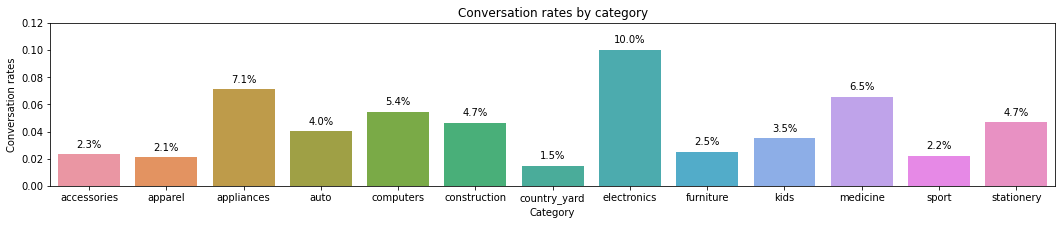

In [25]:
#creating a plot that represents conversion rates by categories
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='Conversion_rate',data=category_summary_table)
for p in plot.patches:
    plot.annotate("{:.1%}".format(p.get_height()),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Conversation rates by category')
plt.xlabel('Category')
plt.ylabel('Conversation rates')
plt.ylim(0,category_summary_table['Conversion_rate'].max()*1.2);

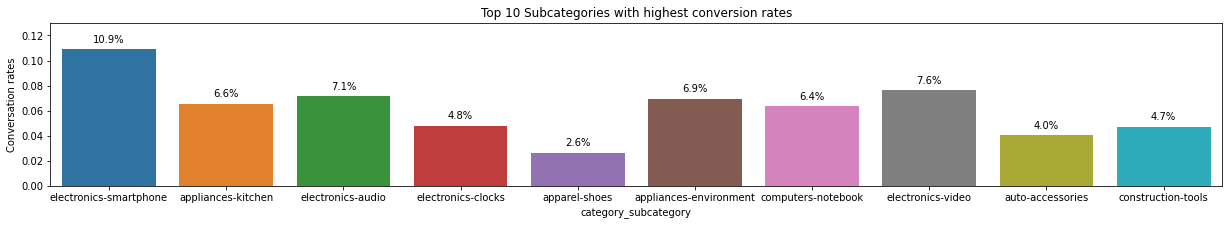

In [26]:
#creating a plot that represents subcategories with highest conversion rates
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='Conversion_rate',data=category_subcategory_summary_table_sorted.head(10))
for p in plot.patches:
    plot.annotate("{:.1%}".format(p.get_height()),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Top 10 Subcategories with highest conversion rates')
plt.ylabel('Conversation rates')
plt.ylim(0,category_summary_table['Conversion_rate'].max()*1.3);

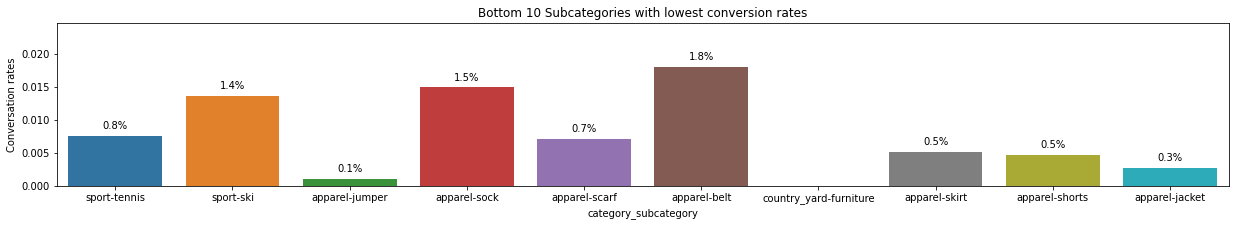

In [27]:
#creating a plot that represents subcategories with lowest conversion rates
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='Conversion_rate',data=category_subcategory_summary_table_sorted.tail(10))
for p in plot.patches:
    plot.annotate("{:.1%}".format(p.get_height()),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')
plt.title('Bottom 10 Subcategories with lowest conversion rates')
plt.ylabel('Conversation rates')
plt.ylim(0,plot.get_ybound()[1]*1.3);

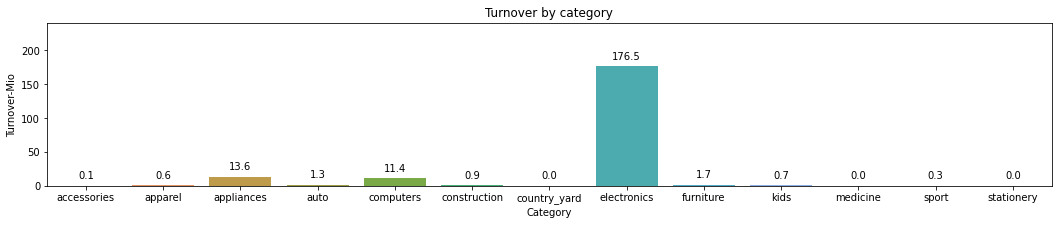

In [28]:
#creating a category turnover table
category_turnover_table=category_summary_table.groupby(by=['category']).agg(total_turnover=('Amount_of_purchase','sum')).reset_index()
category_turnover_table['total_turn_over_mio']=category_turnover_table['total_turnover']/1000000
#ploting the category turnover table 
plt.figure(figsize=(18,3))
plot = sns.barplot(x='category',y='total_turn_over_mio',data=category_turnover_table)

for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.1f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Turnover by category')
plt.xlabel('Category')
plt.ylabel('Turnover-Mio')
plt.ylim(0,plot.get_ybound()[1]*1.3);

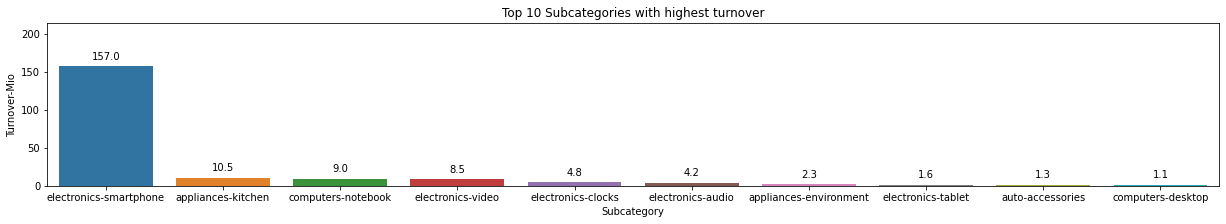

In [29]:
#creating a subcategory turnover table
subcategory_turnover_table=category_subcategory_summary_table.groupby(by=['category_subcategory']).agg(total_turnover=('Amount_of_purchase','sum')).reset_index()
subcategory_turnover_table=subcategory_turnover_table.sort_values(by=['total_turnover'],ascending=False)
subcategory_turnover_table['total_turn_over_mio']=subcategory_turnover_table['total_turnover']/1000000

#ploting top 10 subcategories with the highest turnover 
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='total_turn_over_mio',data=subcategory_turnover_table.head(10))

for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.1f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Top 10 Subcategories with highest turnover')
plt.xlabel('Subcategory')
plt.ylabel('Turnover-Mio')
plt.ylim(0,plot.get_ybound()[1]*1.3);

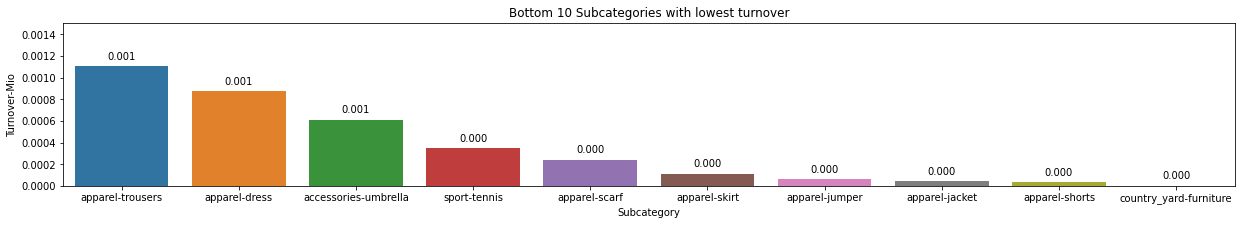

In [30]:
#ploting top 10 subcategories with the lowest turnover 
plt.figure(figsize=(21,3))
plot = sns.barplot(x='category_subcategory',y='total_turn_over_mio',data=subcategory_turnover_table.tail(10))

for p in plot.patches:
    plot.annotate(format(p.get_height(), ',.3f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center',
                  va = 'center', 
                  xytext = (0, 10), 
                  textcoords = 'offset points')

plt.title('Bottom 10 Subcategories with lowest turnover')
plt.xlabel('Subcategory')
plt.ylabel('Turnover-Mio')
plt.ylim(0,plot.get_ybound()[1]*1.3);